In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import shutil
import os

src_path = "/content/drive/MyDrive/labeled_faces"
dst_path = "/content/labeled_faces"

# Hanya salin jika folder belum ada
if not os.path.exists(dst_path):
    shutil.copytree(src_path, dst_path)
    print("✅ Dataset berhasil disalin ke local runtime.")
else:
    print("📁 Folder sudah ada di runtime Colab.")

✅ Dataset berhasil disalin ke local runtime.


Kelas 'winter': 8510 data
Kelas 'spring': 8410 data
Kelas 'summer': 8319 data
Kelas 'autumn': 8533 data


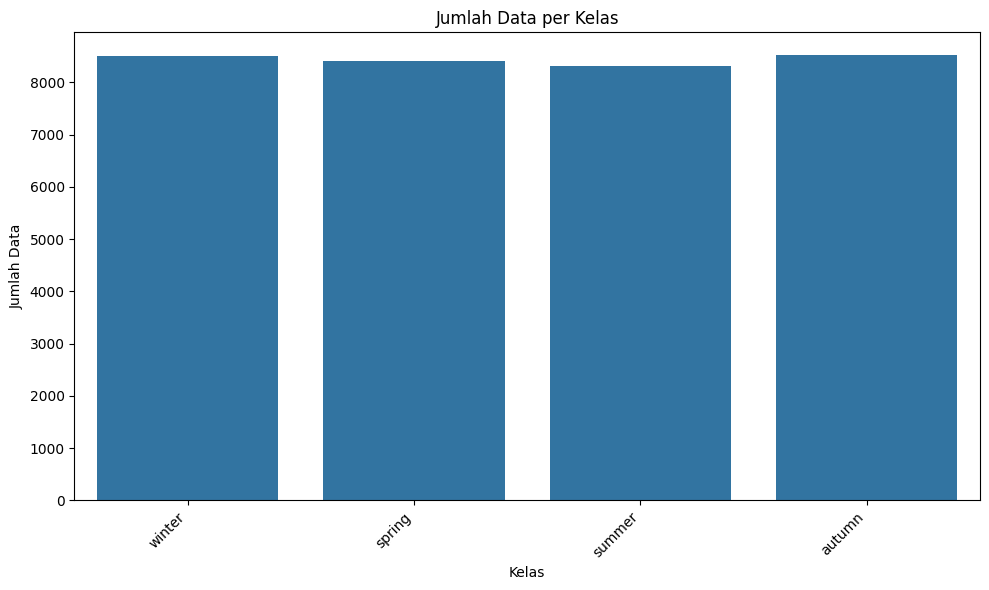

In [4]:
import glob

# Direktori gabungan
combined_dir = "labeled_faces"

# Dapatkan daftar semua subdirektori (kelas) dalam direktori gabungan
classes = [d for d in os.listdir(combined_dir) if os.path.isdir(os.path.join(combined_dir, d))]

# Hitung jumlah file (data) di setiap kelas
class_counts = {}
for cls in classes:
    class_dir = os.path.join(combined_dir, cls)
    class_counts[cls] = len(glob.glob(os.path.join(class_dir, '*')))

# Tampilkan jumlah data per kelas
for cls, count in class_counts.items():
    print(f"Kelas '{cls}': {count} data")

# Opsional: Tampilkan dalam bentuk bar chart untuk visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Jumlah Data per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
import os
import shutil

# Direktori dataset musiman
season_dirs = ["labeled_faces/autumn", "labeled_faces/spring", "labeled_faces/summer", "labeled_faces/winter"]

# Direktori gabungan output
combined_dir = "dataset_combined"
os.makedirs(combined_dir, exist_ok=True)

# Gabungkan semua data dari setiap musim
for season in season_dirs:
    for subset in ["train", "test"]:
        subset_path = os.path.join(season, subset)
        if os.path.exists(subset_path):
            for category in os.listdir(subset_path):
                category_dir = os.path.join(subset_path, category)
                if os.path.isdir(category_dir):
                    target_dir = os.path.join(combined_dir, category)
                    os.makedirs(target_dir, exist_ok=True)

                    for file in os.listdir(category_dir):
                        src_file = os.path.join(category_dir, file)
                        dst_file = os.path.join(target_dir, file)
                        shutil.copy2(src_file, dst_file)

In [6]:
# Menghitung jumlah gambar di setiap kelas dalam direktori gabungan
print("Jumlah gambar per kelas dalam dataset gabungan:")
for category in os.listdir(combined_dir):
    category_path = os.path.join(combined_dir, category)
    if os.path.isdir(category_path):
        num_images = len(os.listdir(category_path))
        print(f"- {category}: {num_images} gambar")


Jumlah gambar per kelas dalam dataset gabungan:


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (150, 150)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    'labeled_faces',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    'labeled_faces',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 27019 images belonging to 4 classes.
Found 6753 images belonging to 4 classes.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')  # 4 kelas
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.4622 - loss: 1.2164

845/845 ━━━━━━━━━━━━━━━━━━━━ 457s 533ms/step - accuracy: 0.4623 - loss: 1.2162 - val_accuracy: 0.6430 - val_loss: 0.8499
Epoch 2/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.6299 - loss: 0.8768

845/845 ━━━━━━━━━━━━━━━━━━━━ 457s 486ms/step - accuracy: 0.6299 - loss: 0.8768 - val_accuracy: 0.6310 - val_loss: 0.8455
Epoch 3/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 404s 478ms/step - accuracy: 0.6473 - loss: 0.8353 - val_accuracy: 0.6011 - val_loss: 0.8974
Epoch 4/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.6499 - loss: 0.8258

845/845 ━━━━━━━━━━━━━━━━━━━━ 380s 449ms/step - accuracy: 0.6500 - loss: 0.8258 - val_accuracy: 0.6606 - val_loss: 0.7860
Epoch 5/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.6747 - loss: 0.7875

845/845 ━━━━━━━━━━━━━━━━━━━━ 371s 440ms/step - accuracy: 0.6747 - loss: 0.7875 - val_accuracy: 0.6837 - val_loss: 0.7606
Epoch 6/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 374s 442ms/step - accuracy: 0.6757 - loss: 0.7773 - val_accuracy: 0.6572 - val_loss: 0.7975
Epoch 7/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 364s 430ms/step - accuracy: 0.6833 - loss: 0.7582 - val_accuracy: 0.6517 - val_loss: 0.7934
Epoch 8/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 372s 441ms/step - accuracy: 0.6939 - loss: 0.7382 - val_accuracy: 0.6710 - val_loss: 0.8033
Epoch 9/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.6994 - loss: 0.7232

845/845 ━━━━━━━━━━━━━━━━━━━━ 379s 449ms/step - accuracy: 0.6994 - loss: 0.7232 - val_accuracy: 0.6745 - val_loss: 0.7559
Epoch 10/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.6979 - loss: 0.7199

845/845 ━━━━━━━━━━━━━━━━━━━━ 382s 452ms/step - accuracy: 0.6979 - loss: 0.7199 - val_accuracy: 0.6770 - val_loss: 0.7515
Epoch 11/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.6987 - loss: 0.7229

845/845 ━━━━━━━━━━━━━━━━━━━━ 371s 439ms/step - accuracy: 0.6987 - loss: 0.7228 - val_accuracy: 0.6827 - val_loss: 0.7462
Epoch 12/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 379s 449ms/step - accuracy: 0.7157 - loss: 0.6874 - val_accuracy: 0.6862 - val_loss: 0.7501
Epoch 13/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.7182 - loss: 0.6813

845/845 ━━━━━━━━━━━━━━━━━━━━ 376s 445ms/step - accuracy: 0.7182 - loss: 0.6813 - val_accuracy: 0.6837 - val_loss: 0.7450
Epoch 14/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 383s 454ms/step - accuracy: 0.7211 - loss: 0.6750 - val_accuracy: 0.6821 - val_loss: 0.7622
Epoch 15/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 372s 440ms/step - accuracy: 0.7153 - loss: 0.6776 - val_accuracy: 0.6942 - val_loss: 0.7508
Epoch 16/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.7193 - loss: 0.6764

845/845 ━━━━━━━━━━━━━━━━━━━━ 374s 443ms/step - accuracy: 0.7193 - loss: 0.6764 - val_accuracy: 0.6924 - val_loss: 0.7174
Epoch 17/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 383s 444ms/step - accuracy: 0.7278 - loss: 0.6616 - val_accuracy: 0.6798 - val_loss: 0.7534
Epoch 18/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 378s 448ms/step - accuracy: 0.7203 - loss: 0.6745 - val_accuracy: 0.6653 - val_loss: 0.7863
Epoch 19/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 382s 453ms/step - accuracy: 0.7289 - loss: 0.6457 - val_accuracy: 0.6754 - val_loss: 0.7565
Epoch 20/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 385s 455ms/step - accuracy: 0.7195 - loss: 0.6685 - val_accuracy: 0.6784 - val_loss: 0.7757


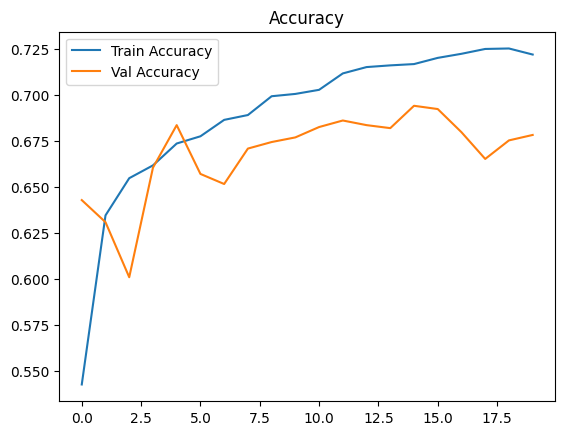

212/212 ━━━━━━━━━━━━━━━━━━━━ 75s 347ms/step
              precision    recall  f1-score   support

      autumn       0.26      0.22      0.24      1706
      spring       0.25      0.27      0.26      1682
      summer       0.24      0.26      0.25      1663
      winter       0.27      0.27      0.27      1702

    accuracy                           0.25      6753
   macro avg       0.25      0.25      0.25      6753
weighted avg       0.25      0.25      0.25      6753



In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Classification report
val_generator.reset()
y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator), axis=1)
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))


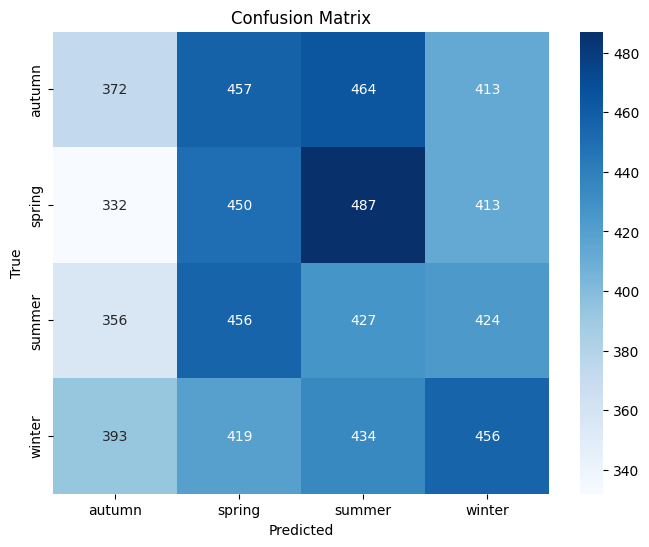

In [11]:
# prompt: confussion matrix

import matplotlib.pyplot as plt
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# Salin file ke Google Drive
!cp best_model.h5 /content/drive/MyDrive/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
Prediksi musim untuk gambar adalah: autumn


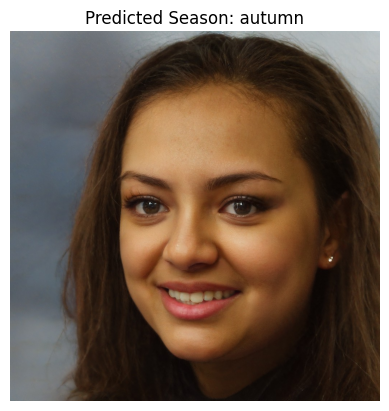

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load model terbaik
model = load_model('/content/drive/MyDrive/best_model.h5')  # Pastikan path benar

# Preprocessing gambar
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(150, 150))        # Resize gambar
    img_array = img_to_array(img)                             # Convert to array
    img_array = np.expand_dims(img_array, axis=0)             # Tambah dimensi batch
    img_array /= 255.0                                        # Normalisasi (sama seperti training)
    return img_array

# Fungsi prediksi musim
def predict_season(image_path, class_indices):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction, axis=1)[0]

    # Konversi indeks menjadi label kelas
    label_map = {v: k for k, v in class_indices.items()}
    predicted_class = label_map[class_index]
    return predicted_class

# Gambar yang ingin di-infer
image_path = '/content/autumn_faces.jpg'  # Ganti sesuai file Anda

# Mapping class dari training generator
class_indices = train_generator.class_indices  # Harus sesuai saat training

# Cek file dan lakukan prediksi
if os.path.exists(image_path):
    predicted_label = predict_season(image_path, class_indices)
    print(f"Prediksi musim untuk gambar adalah: {predicted_label}")

    # Tampilkan gambar dengan label
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title(f"Predicted Season: {predicted_label}")
    plt.axis('off')
    plt.show()
else:
    print(f"File tidak ditemukan di: {image_path}")
